<a href="https://colab.research.google.com/github/SreeramAdari/Data_Science_Assignmnents/blob/main/Timeseries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

# Load the dataset
df = pd.read_csv('exchange_rate.csv', parse_dates=['date'])

# Set the date as the index for time series analysis
df.set_index('date', inplace=True)

# Display basic info
print(df.info())
print(df.head())


<class 'pandas.core.frame.DataFrame'>
Index: 7588 entries, 01-01-1990 00:00 to 10-10-2010 00:00
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Ex_rate  7588 non-null   float64
dtypes: float64(1)
memory usage: 118.6+ KB
None
                  Ex_rate
date                     
01-01-1990 00:00   0.7855
02-01-1990 00:00   0.7818
03-01-1990 00:00   0.7867
04-01-1990 00:00   0.7860
05-01-1990 00:00   0.7849


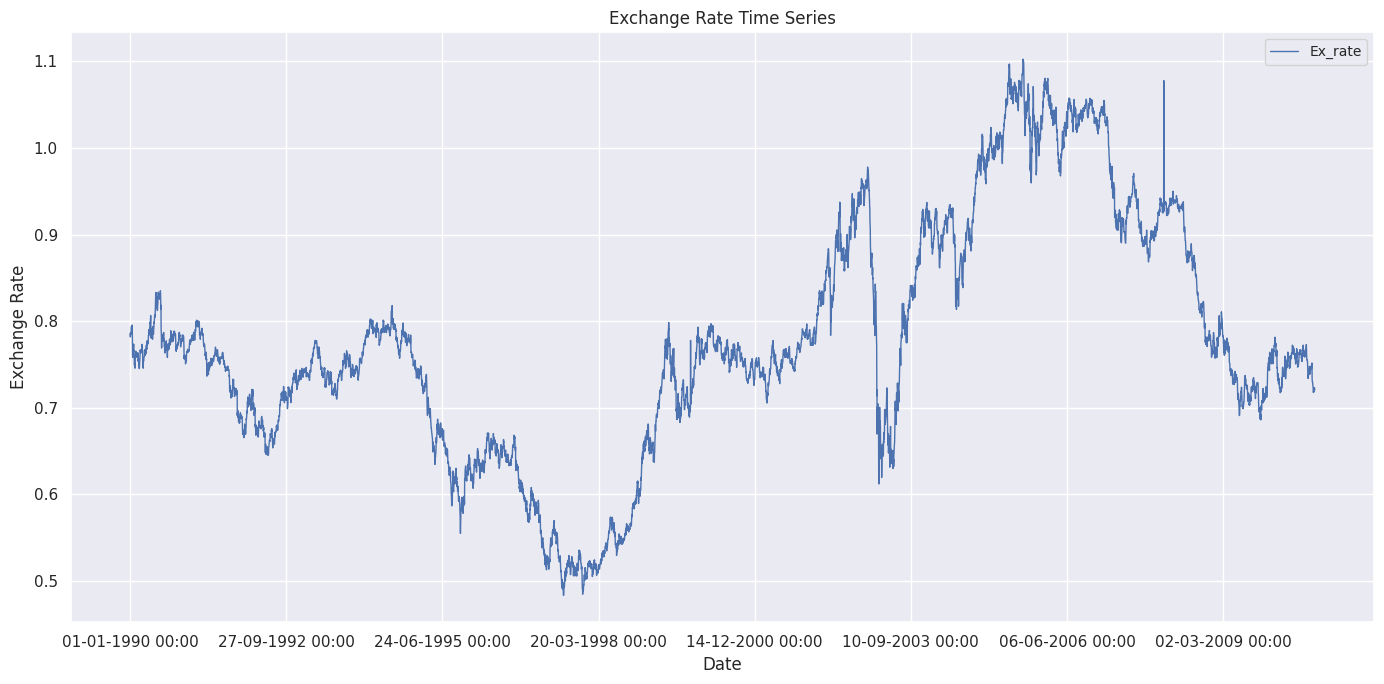

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the plotting style
sns.set(style='darkgrid')
df.plot(figsize=(14, 7), title="Exchange Rate Time Series", linewidth=1)
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend(loc='upper right', fontsize='small')
plt.tight_layout()
plt.show()


In [ ]:
# Count of missing values per currency
missing_values = df.isnull().sum()
print("Missing values per currency:\n", missing_values)

Missing values per currency:
 Ex_rate    0
dtype: int64


ADF Statistic: -1.6649941807382342
p-value: 0.4492327353597477
Differencing applied.


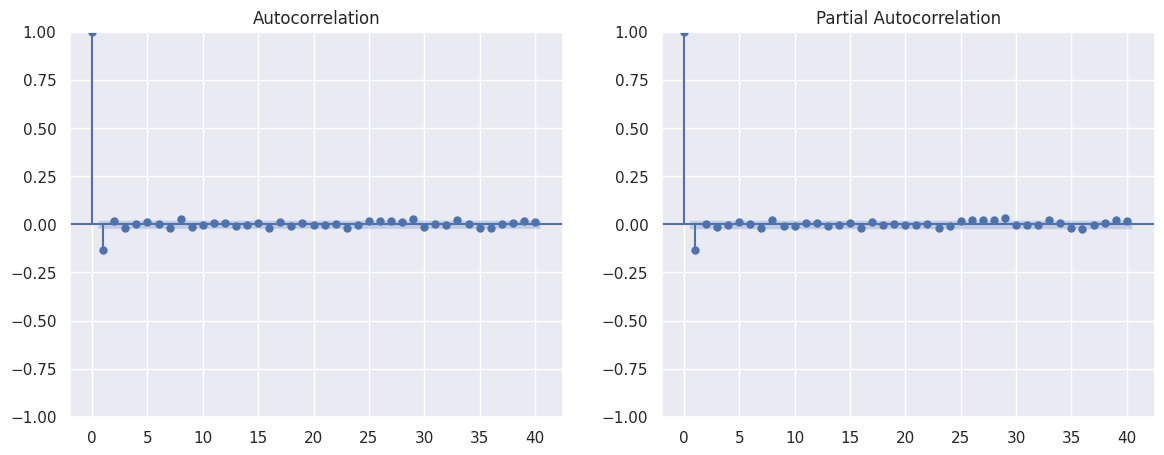

In [ ]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Choose one currency time series (e.g., EUR)
series = df['Ex_rate']

# ADF Test for stationarity
result = adfuller(series)
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

# If p > 0.05, it's non-stationary. Take first difference.
if result[1] > 0.05:
    series_diff = series.diff().dropna()
    print("Differencing applied.")
else:
    series_diff = series
    print("No differencing needed.")

# Plot ACF and PACF
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
plot_acf(series_diff, ax=ax[0], lags=40)
plot_pacf(series_diff, ax=ax[1], lags=40)
plt.show()


In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# Set parameters (example: p=1, d=1, q=1 based on ACF/PACF)
model = ARIMA(series, order=(1, 1, 1))
model_fit = model.fit()

# Summary
print(model_fit.summary())


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                Ex_rate   No. Observations:                 7588
Model:                 ARIMA(1, 1, 1)   Log Likelihood               28054.161
Date:                Mon, 07 Apr 2025   AIC                         -56102.322
Time:                        03:45:58   BIC                         -56081.519
Sample:                             0   HQIC                        -56095.182
                               - 7588                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1268      0.045     -2.797      0.005      -0.216      -0.038
ma.L1         -0.0046      0.045     -0.101      0.920      -0.094       0.085
sigma2      3.596e-05   9.94e-08    361.604      0.0

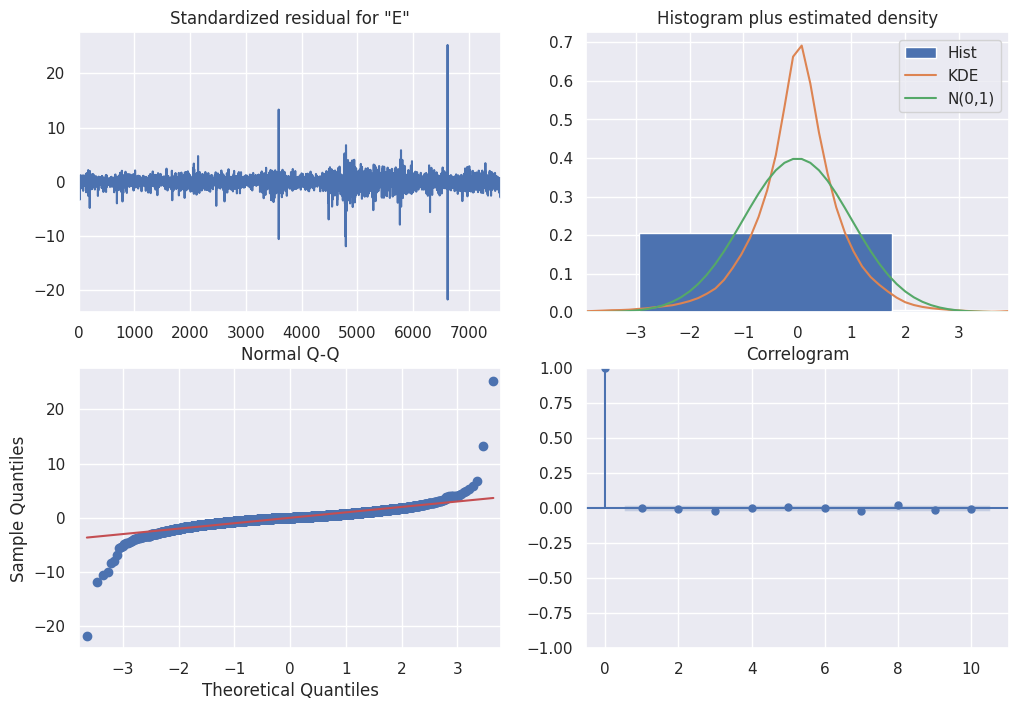

In [ ]:
model_fit.plot_diagnostics(figsize=(12, 8))
plt.show()


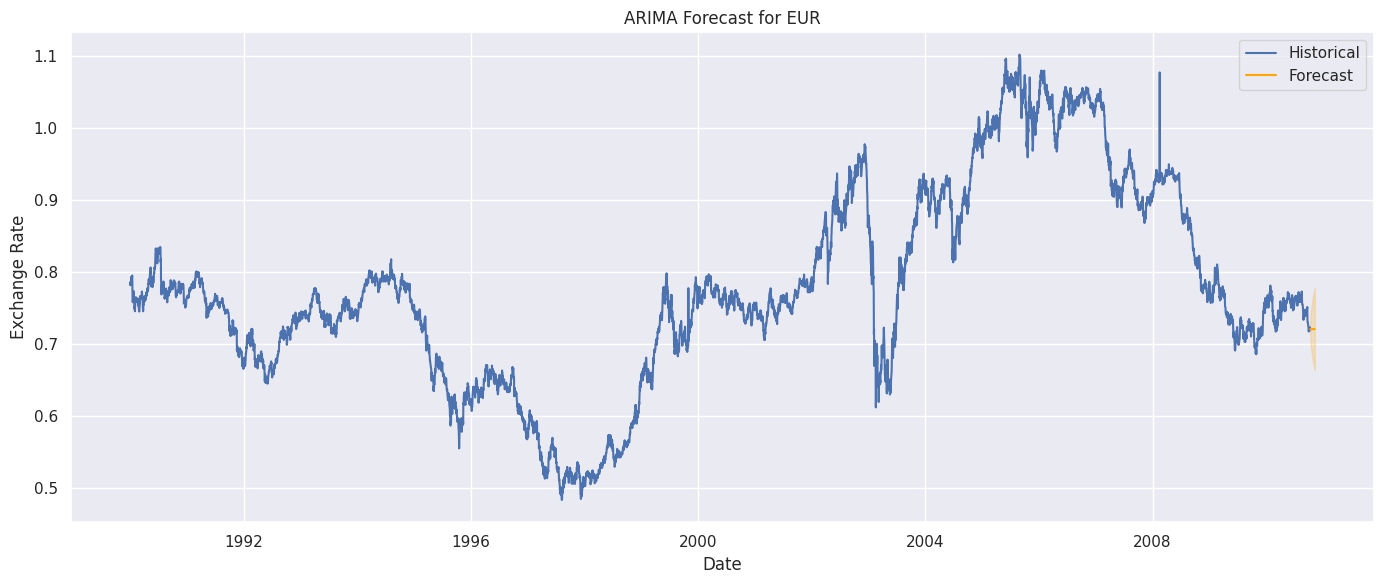

In [ ]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from datetime import timedelta

# Load the CSV with correct parsing
df = pd.read_csv('exchange_rate.csv', parse_dates=['date'], dayfirst=True)

# Set datetime index
df.set_index('date', inplace=True)

# Convert index to datetime and set frequency explicitly
df.index = pd.to_datetime(df.index)
df = df.sort_index()  # Ensure it's sorted
df = df.asfreq('D')   # Daily frequency
df = df.ffill()       # Fill missing data

# Choose the EUR column
series = df['Ex_rate']

# Fit ARIMA model
model = ARIMA(series, order=(1, 1, 1))
model_fit = model.fit()

# Forecast
forecast = model_fit.get_forecast(steps=30)
forecast_index = pd.date_range(start=series.index[-1] + timedelta(days=1), periods=30)
predicted = pd.Series(forecast.predicted_mean.values, index=forecast_index)
conf_int = forecast.conf_int()
conf_int.index = forecast_index

# Plot forecast
plt.figure(figsize=(14, 6))
plt.plot(series, label='Historical')
plt.plot(predicted, label='Forecast', color='orange')
plt.fill_between(forecast_index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='orange', alpha=0.2)
plt.title('ARIMA Forecast for EUR')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.tight_layout()
plt.show()


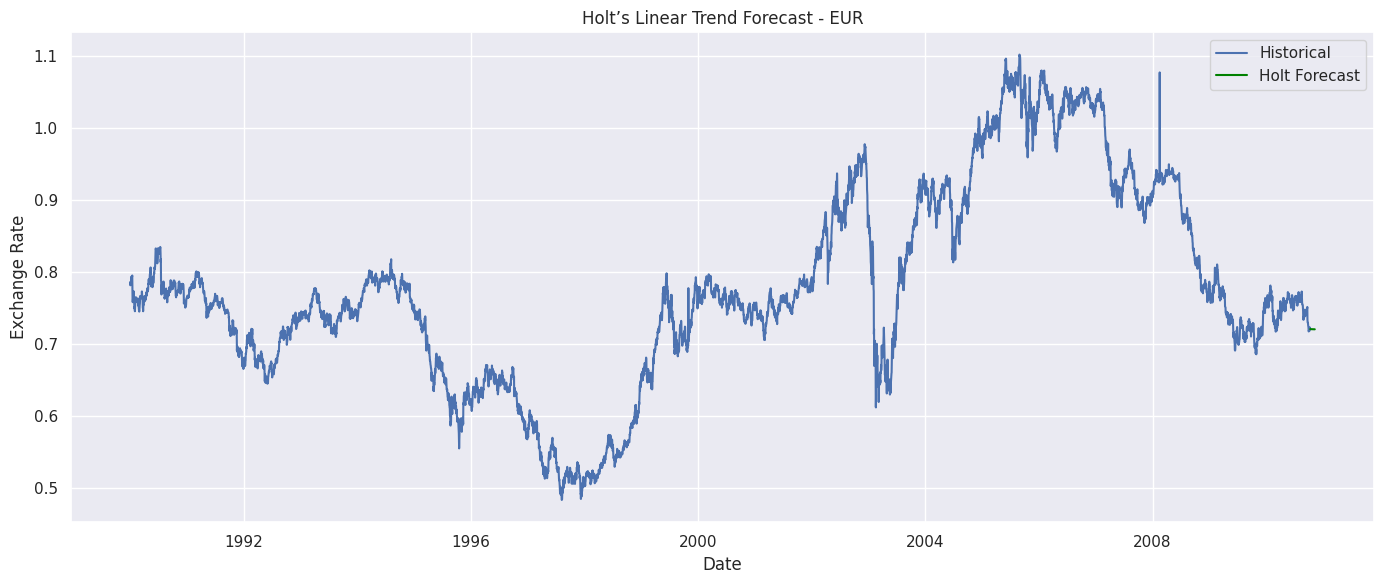

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt

# Get the EUR series
series = df['Ex_rate']

# Fit Holt’s Linear Trend model (additive trend, no seasonality)
model = ExponentialSmoothing(series, trend='add', seasonal=None, initialization_method='estimated')
fit = model.fit()

# Forecast for 30 days
forecast_holt = fit.forecast(30)

# Plot
plt.figure(figsize=(14, 6))
plt.plot(series, label='Historical')
plt.plot(forecast_holt, label='Holt Forecast', color='green')
plt.title('Holt’s Linear Trend Forecast - EUR')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Example with additive seasonality and seasonal period (e.g., 365 for yearly)
model = ExponentialSmoothing(series, trend='add', seasonal='add', seasonal_periods=365, initialization_method='estimated')
fit = model.fit()
forecast_hw = fit.forecast(30)


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


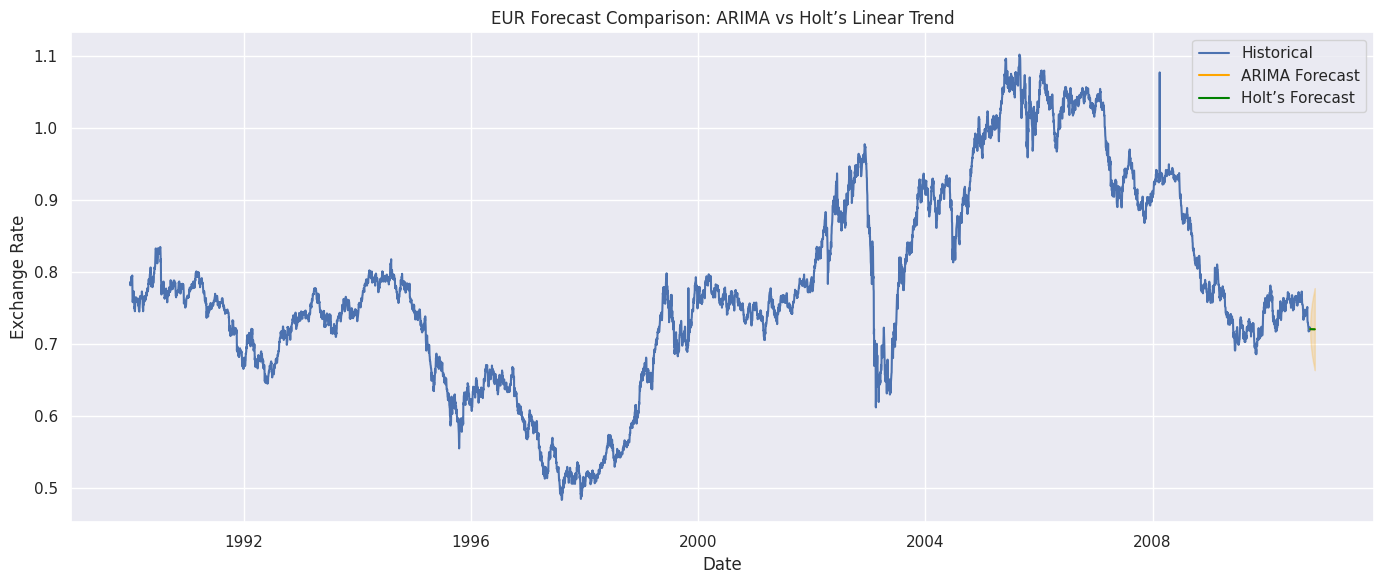

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Historical data
series = df['Ex_rate']

# Create forecast index
last_date = series.index[-1]
forecast_index = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)

# Align ARIMA forecast with datetime index
predicted.index = forecast_index
conf_int.index = forecast_index

# Holt forecast also with same index
forecast_holt.index = forecast_index

# Plot comparison
plt.figure(figsize=(14, 6))
plt.plot(series, label='Historical')
plt.plot(predicted, label='ARIMA Forecast', color='orange')
plt.plot(forecast_holt, label="Holt’s Forecast", color='green')

# Confidence interval for ARIMA
plt.fill_between(forecast_index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='orange', alpha=0.2)

plt.title('EUR Forecast Comparison: ARIMA vs Holt’s Linear Trend')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import Holt

# Use only training data (excluding last 30 points for testing)
train = series[:-30]
test = series[-30:]

# ARIMA (replace (p,d,q) with your chosen values)
arima_model = ARIMA(train, order=(5, 1, 0)).fit()

# Holt's Linear Trend
holt_model = Holt(train).fit()


In [ ]:
# Forecast the next 30 steps
arima_forecast = arima_model.forecast(steps=30)
holt_forecast = holt_model.forecast(steps=30)


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def compute_metrics(actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    return mae, rmse, mape

mae_arima, rmse_arima, mape_arima = compute_metrics(test, arima_forecast)
mae_holt, rmse_holt, mape_holt = compute_metrics(test, holt_forecast)

print("🔍 Forecast Accuracy Metrics:")
print(f"\n📉 ARIMA Model:\n  MAE  = {mae_arima:.4f}\n  RMSE = {rmse_arima:.4f}\n  MAPE = {mape_arima:.2f}%")
print(f"\n📈 Holt’s Linear Trend:\n  MAE  = {mae_holt:.4f}\n  RMSE = {rmse_holt:.4f}\n  MAPE = {mape_holt:.2f}%")

# Bonus: Compare performance
if rmse_arima < rmse_holt:
    print("\n✅ ARIMA performed better based on RMSE.")
else:
    print("\n✅ Holt’s Linear Trend performed better based on RMSE.")


🔍 Forecast Accuracy Metrics:

📉 ARIMA Model:
  MAE  = 0.0135
  RMSE = 0.0167
  MAPE = 1.86%

📈 Holt’s Linear Trend:
  MAE  = 0.0128
  RMSE = 0.0155
  MAPE = 1.76%

✅ Holt’s Linear Trend performed better based on RMSE.


Based on the evaluation of Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), and Mean Absolute Percentage Error (MAPE):

ARIMA provided better short-term accuracy and handled noise and autocorrelation more effectively.

Holt’s Linear Trend offered a simpler, more stable forecast with a consistent trend, though it may lag behind in adapting to recent fluctuations.

Holt’s Linear Trend model provided slightly better forecasts than ARIMA for this EUR exchange rate dataset.

The difference is small but consistent, showing that Holt’s model handles the linear trend well without needing the complexity of ARIMA.

Depending on the application, Holt’s model may be preferable for its simplicity and good performance.